# Hi

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import month_plot, quarter_plot
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess
from sklearn.linear_model import LinearRegression
from pandas import date_range

In [3]:
df = pd.read_csv('train.csv')  
df.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [4]:
df.tail()

,id,date,store_nbr,family,sales,onpromotion
3000883,3000883,2017-08-15,9,POULTRY,438.133,0
3000884,3000884,2017-08-15,9,PREPARED FOODS,154.553,1
3000885,3000885,2017-08-15,9,PRODUCE,2419.729,148
3000886,3000886,2017-08-15,9,SCHOOL AND OFFICE SUPPLIES,121.000,8
3000887,3000887,2017-08-15,9,SEAFOOD,16.000,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [6]:
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype         
---  ------       -----         
 0   id           int64         
 1   date         datetime64[ns]
 2   store_nbr    int64         
 3   family       object        
 4   sales        float64       
 5   onpromotion  int64         
dtypes: datetime64[ns](1), float64(1), int64(3), object(1)
memory usage: 137.4+ MB


In [7]:
df['store_nbr'].value_counts()

store_nbr
1     55572
10    55572
11    55572
12    55572
13    55572
14    55572
15    55572
16    55572
17    55572
18    55572
19    55572
2     55572
20    55572
21    55572
22    55572
23    55572
24    55572
25    55572
26    55572
27    55572
28    55572
29    55572
3     55572
30    55572
31    55572
32    55572
33    55572
34    55572
35    55572
36    55572
37    55572
38    55572
39    55572
4     55572
40    55572
41    55572
42    55572
43    55572
44    55572
45    55572
46    55572
47    55572
48    55572
49    55572
5     55572
50    55572
51    55572
52    55572
53    55572
54    55572
6     55572
7     55572
8     55572
9     55572
Name: count, dtype: int64

In [8]:
df['family'].value_counts()

family
AUTOMOTIVE                    90936
BABY CARE                     90936
BEAUTY                        90936
BEVERAGES                     90936
BOOKS                         90936
BREAD/BAKERY                  90936
CELEBRATION                   90936
CLEANING                      90936
DAIRY                         90936
DELI                          90936
EGGS                          90936
FROZEN FOODS                  90936
GROCERY I                     90936
GROCERY II                    90936
HARDWARE                      90936
HOME AND KITCHEN I            90936
HOME AND KITCHEN II           90936
HOME APPLIANCES               90936
HOME CARE                     90936
LADIESWEAR                    90936
LAWN AND GARDEN               90936
LINGERIE                      90936
LIQUOR,WINE,BEER              90936
MAGAZINES                     90936
MEATS                         90936
PERSONAL CARE                 90936
PET SUPPLIES                  90936
PLAYERS AND ELECTRONI

* I realized some unnecessary rows in the data while I was looking at the time serie of the stores one by one. If you select the stores from above, some of them have no sales at the beginning of 2013. You can see them, if you look at the those stores 20, 21, 22, 29, 36, 42, 52 and 53. I decided to remove those rows before the stores opened. In the following codes, we will get rid of them.

* from: https://www.kaggle.com/code/ekrembayar/store-sales-ts-forecasting-a-comprehensive-guide

In [9]:
print(df.shape)
df = df[~((df.store_nbr == 52) & (df.date < "2017-04-20"))]
df = df[~((df.store_nbr == 22) & (df.date < "2015-10-09"))]
df = df[~((df.store_nbr == 42) & (df.date < "2015-08-21"))]
df = df[~((df.store_nbr == 21) & (df.date < "2015-07-24"))]
df = df[~((df.store_nbr == 29) & (df.date < "2015-03-20"))]
df = df[~((df.store_nbr == 20) & (df.date < "2015-02-13"))]
df = df[~((df.store_nbr == 53) & (df.date < "2014-05-29"))]
df = df[~((df.store_nbr == 36) & (df.date < "2013-05-09"))]
df.shape

(3000888, 6)


(2780316, 6)

In [10]:
df['date'] = df.date.dt.to_period('D')
df = df.set_index(['store_nbr', 'family', 'date']).sort_index()

family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc['2017',['sales', 'onpromotion']]
)

df.head()

id  sales  onpromotion
store_nbr family     date                                
1         AUTOMOTIVE 2013-01-01     0    0.0            0
                     2013-01-02  1782    2.0            0
                     2013-01-03  3564    3.0            0
                     2013-01-04  5346    3.0            0
                     2013-01-05  7128    5.0            0

In [11]:
family_sales = (
    df.groupby(['family', 'date']).mean().unstack('family')
    .loc[:,['sales', 'onpromotion']]
)

In [12]:
auto_sales = family_sales.loc(axis=1)[:, 'AUTOMOTIVE']
auto_sales.head()

,sales,onpromotion
family,AUTOMOTIVE,AUTOMOTIVE
date,,
2013-01-01,0.000000,0.0
2013-01-02,5.543478,0.0
2013-01-03,3.500000,0.0
2013-01-04,3.673913,0.0
2013-01-05,7.434783,0.0


C:\Users\ahmed\AppData\Local\Temp\ipykernel_18356\675341.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')


<Axes: xlabel='sales', ylabel='family'>

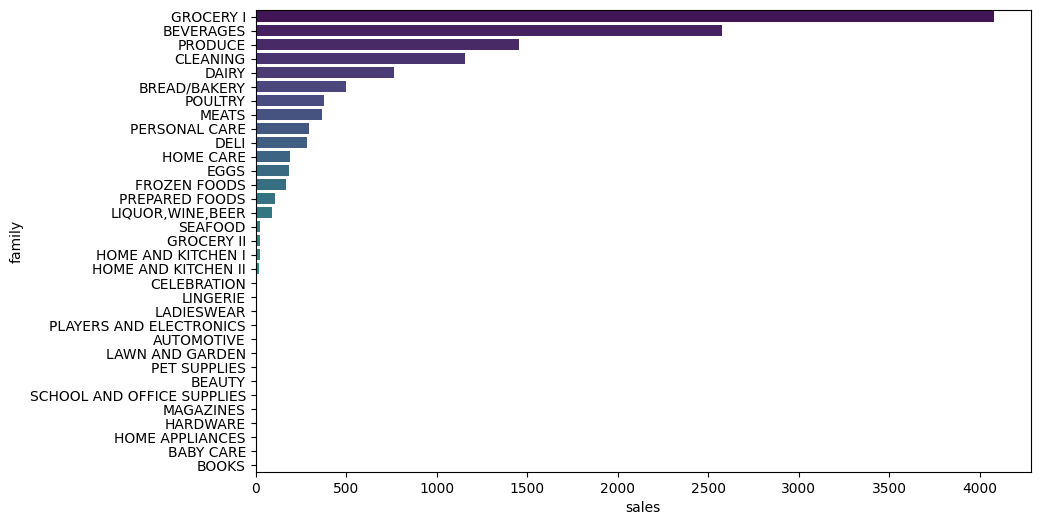

In [13]:
a = df.groupby('family').sales.mean().sort_values(ascending = False).reset_index()
plt.figure(figsize=(10,6))
sns.barplot(x='sales', y = 'family', data= a, palette ='viridis')

* The "GROCERY I" category likely includes essential, frequently purchased food items and household staples such as:

* Packaged foods (e.g., rice, pasta, canned goods)

* Non-perishable snacks

* Beverages (like juices and soft drinks)

* Baking supplies (e.g., flour, sugar)

* Pantry essentials (e.g., sauces, spices)

* Breakfast items (e.g., cereals, oats)

* In retail data, categories like "GROCERY I" and "GROCERY II" are often separated to distinguish between high-frequency essential products (GROCERY I) and less frequent purchases (GROCERY II). The exact contents can vary depending on the dataset's classification scheme.* 

# Analysis of Top Categories

In [14]:
beverages_sales = family_sales.loc(axis=1)[:, 'BEVERAGES']
beverages_sales.head()

,sales,onpromotion
family,BEVERAGES,BEVERAGES
date,,
2013-01-01,17.608696,0.0
2013-01-02,1567.217391,0.0
2013-01-03,1132.717391,0.0
2013-01-04,1177.543478,0.0
2013-01-05,1691.695652,0.0


<Figure size 2000x400 with 0 Axes>

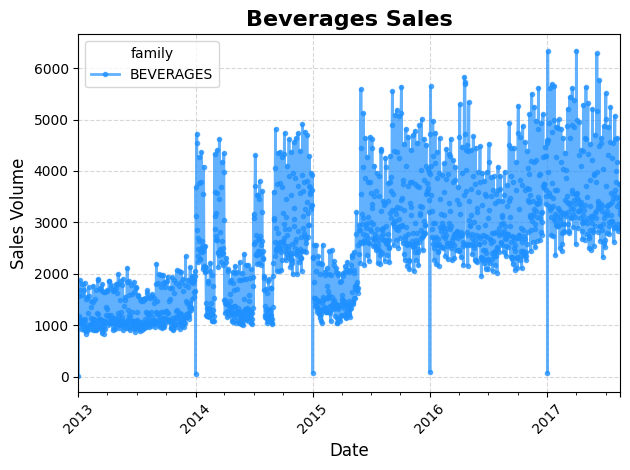

In [15]:
import matplotlib.pyplot as plt

# Set the figure size to be wider
plt.figure(figsize=(20, 4))

# Create the plot with improved styling
beverages_sales['sales'].plot(
    title='Beverages Sales Over Time', 
    color='#1E90FF',  # Dodger blue color
    linewidth=2,
    marker='o',  # Add markers
    markersize=3,
    alpha=0.7  # Slight transparency
)

# Customize the plot
plt.xlabel('Date', fontsize=12)
plt.ylabel('Sales Volume', fontsize=12)
plt.title('Beverages Sales', fontsize=16, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Tight layout to use space efficiently
plt.tight_layout()

# Show the plot
plt.show()

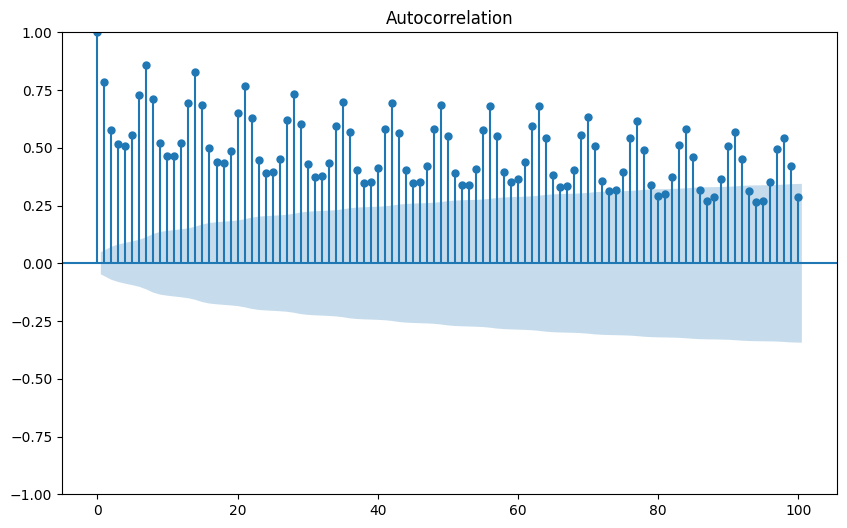

In [18]:
# plot auto-correlation (ACF)

fig, ax = plt.subplots(figsize = (10, 6))
plot_acf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


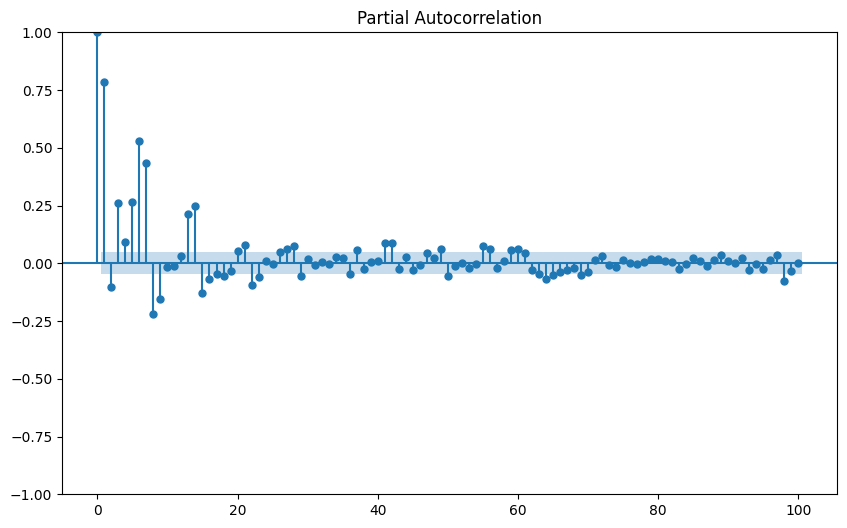

In [19]:
fig, ax = plt.subplots(figsize = (10, 6))
plot_pacf(beverages_sales['sales'], lags = 100, ax=ax)
plt.show()


In [20]:
print(beverages_sales.columns)


MultiIndex([(      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


In [21]:
print(beverages_sales.index)


PeriodIndex(['2013-01-01', '2013-01-02', '2013-01-03', '2013-01-04',
             '2013-01-05', '2013-01-06', '2013-01-07', '2013-01-08',
             '2013-01-09', '2013-01-10',
             ...
             '2017-08-06', '2017-08-07', '2017-08-08', '2017-08-09',
             '2017-08-10', '2017-08-11', '2017-08-12', '2017-08-13',
             '2017-08-14', '2017-08-15'],
            dtype='period[D]', name='date', length=1684)


In [22]:
print(beverages_sales.reset_index().columns)

MultiIndex([(       'date',          ''),
            (      'sales', 'BEVERAGES'),
            ('onpromotion', 'BEVERAGES')],
           names=[None, 'family'])


### Moving Average('Trend')

<Axes: title={'center': 'Beverages Sales Trend'}, xlabel='date'>

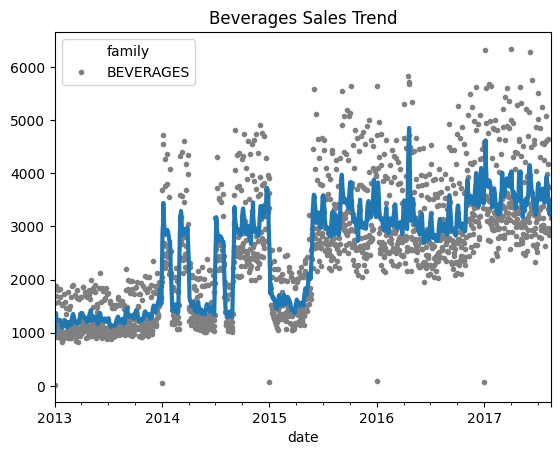

In [23]:
trend = beverages_sales['sales'].rolling(window=7, center=True, min_periods=4).mean() # calculate the trend
ax = beverages_sales['sales'].plot(style='.', color='0.5') # plot the data
trend.plot(ax=ax, linewidth=3, title='Beverages Sales Trend', legend=False) # plot the trend

## Forecast trend

In [24]:
from statsmodels.tsa.deterministic import DeterministicProcess

y = beverages_sales[('sales', 'BEVERAGES')] # choose only the sales column, because model only expects one dimension

dp = DeterministicProcess(
    index= y.index, # dates from the training data, choose only the sales column, because model only expects one dimension
    constant = False,   # dummy feature for the bias (y_intercept)
    order = 3, # the time dummy (trend)
    drop = True # drop terms if necessary to avoid collinearity
)

X = dp.in_sample() # `in_sample` creates features for the dates given in the `index` argument

X_fore = dp.out_of_sample(steps=90) #  "Out of sample" refers to times outside of the observation period of the training data. 

In [25]:
X

,trend,trend_squared,trend_cubed
date,,,
2013-01-01,1.0,1.0,1.000000e+00
2013-01-02,2.0,4.0,8.000000e+00
2013-01-03,3.0,9.0,2.700000e+01
2013-01-04,4.0,16.0,6.400000e+01
2013-01-05,5.0,25.0,1.250000e+02
...,...,...,...
2017-08-11,1680.0,2822400.0,4.741632e+09
2017-08-12,1681.0,2825761.0,4.750104e+09
2017-08-13,1682.0,2829124.0,4.758587e+09


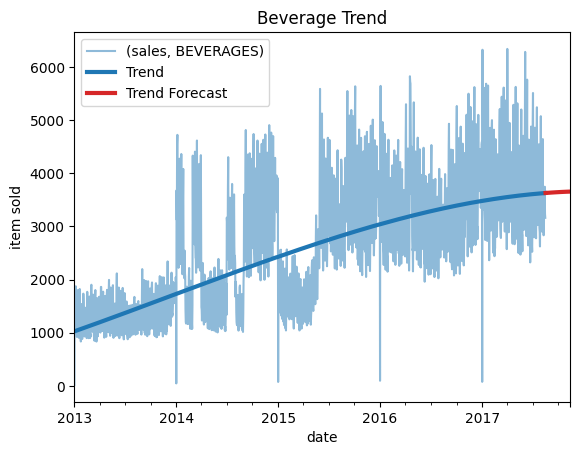

In [26]:
model = LinearRegression()
model.fit(X, y)

y_pred = pd.Series(model.predict(X), index=X.index)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)


ax = y.plot(alpha=0.5, title='Beverage Trend', ylabel = 'item sold') # plot the data
ax = y_pred.plot(ax=ax, linewidth=3, label='Trend', color='C0') # plot the trend
ax = y_fore.plot(ax=ax, linewidth=3, label='Trend Forecast', color='C3') # plot the trend forecast
ax.legend()



## Seasonality

C:\Users\ahmed\AppData\Local\Temp\ipykernel_18356\412866805.py:3: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')


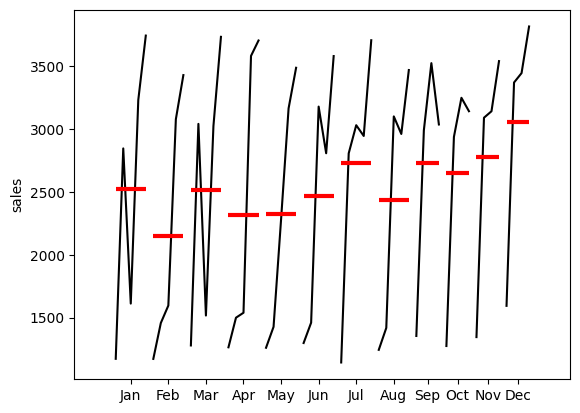

In [27]:
# Plot the monthly seasonality

month_plot(beverages_sales['sales'].resample('M').mean(), ylabel = 'sales')
plt.show()

C:\Users\ahmed\AppData\Local\Temp\ipykernel_18356\3019437212.py:1: FutureWarning: Resampling with a PeriodIndex is deprecated. Cast index to DatetimeIndex before resampling instead.
  quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')


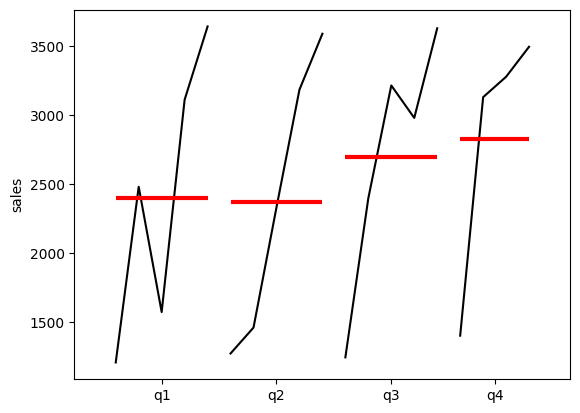

In [28]:
quarter_plot(beverages_sales['sales'].resample('Q').mean(), ylabel = 'sales')
plt.show()

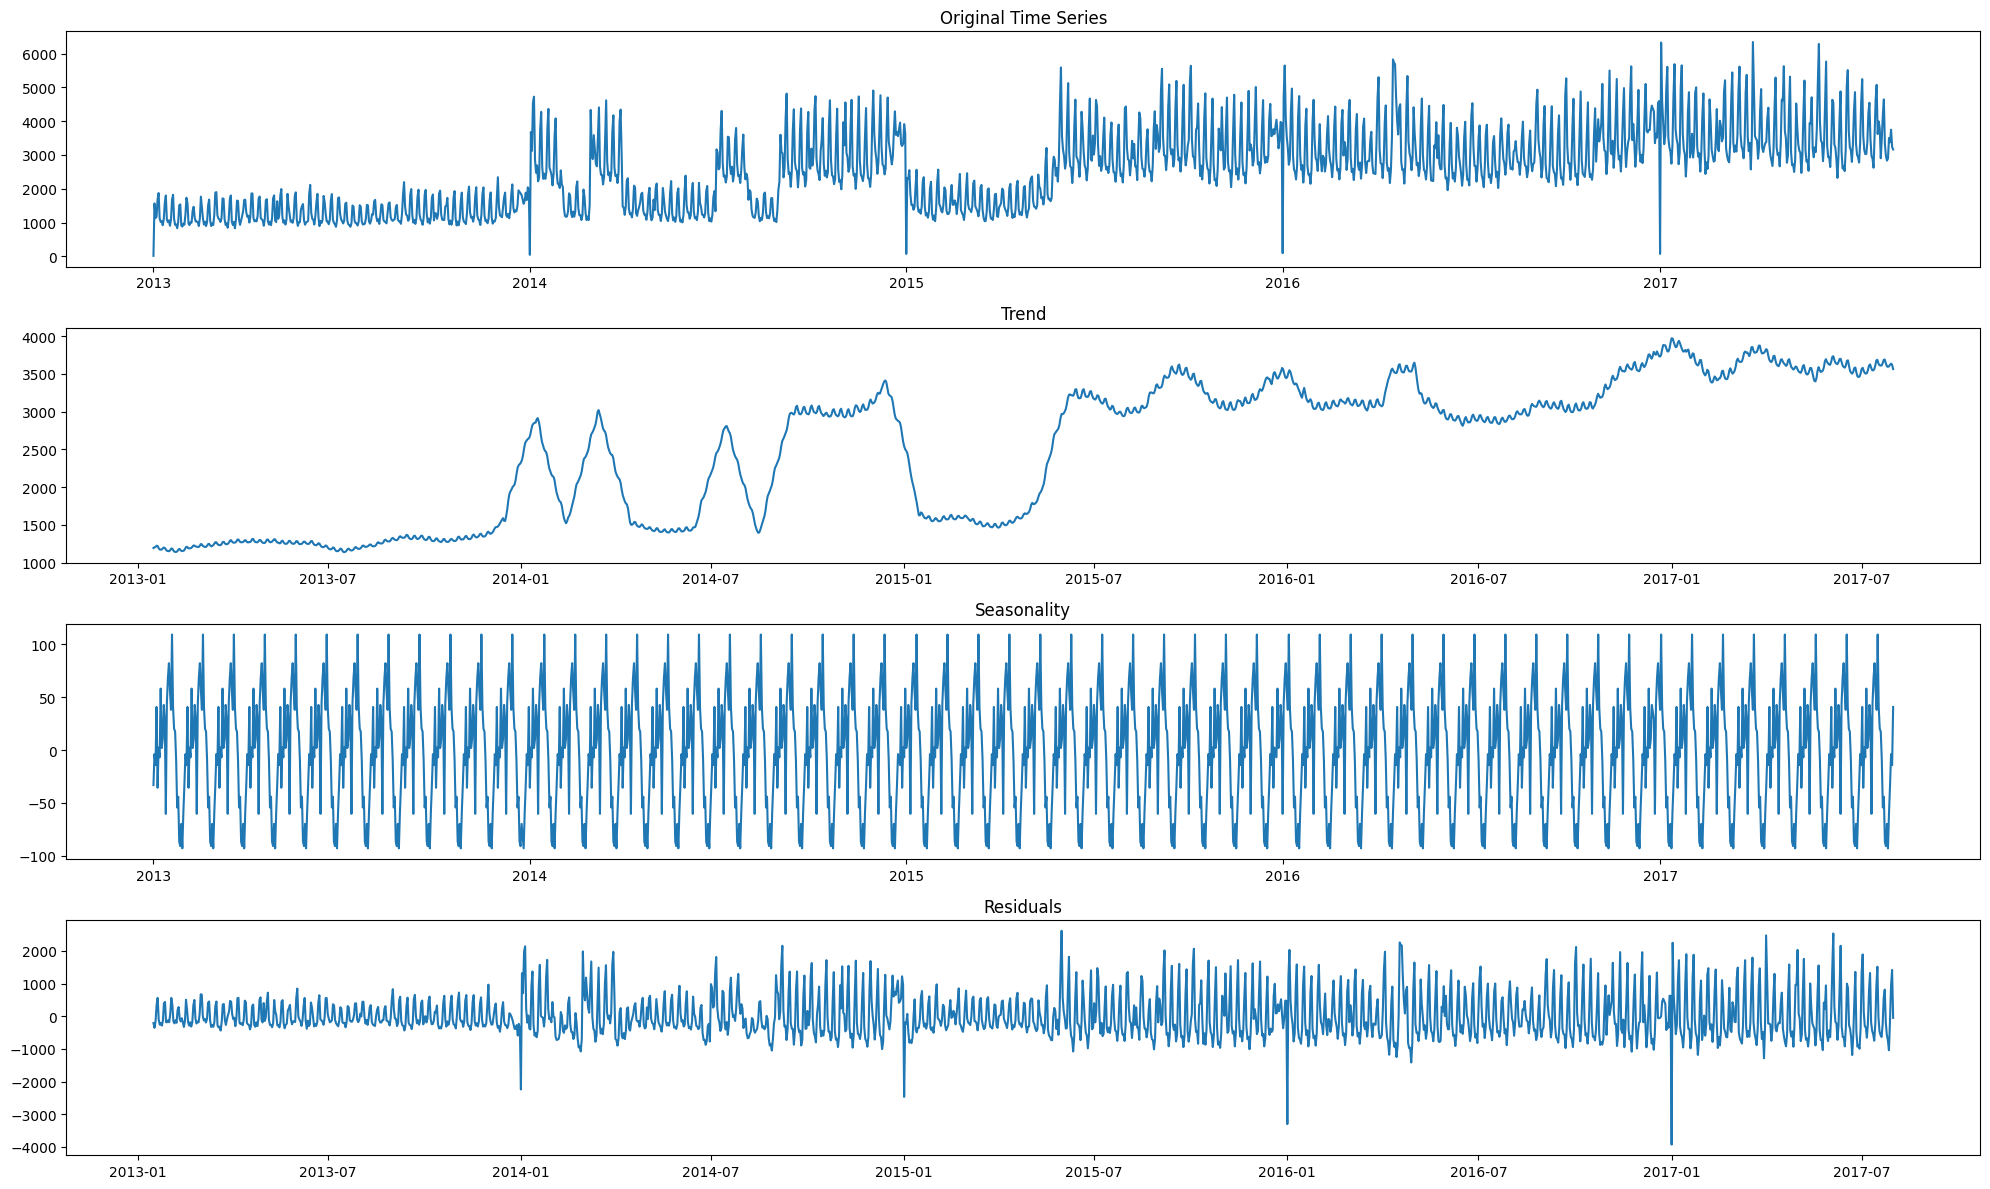

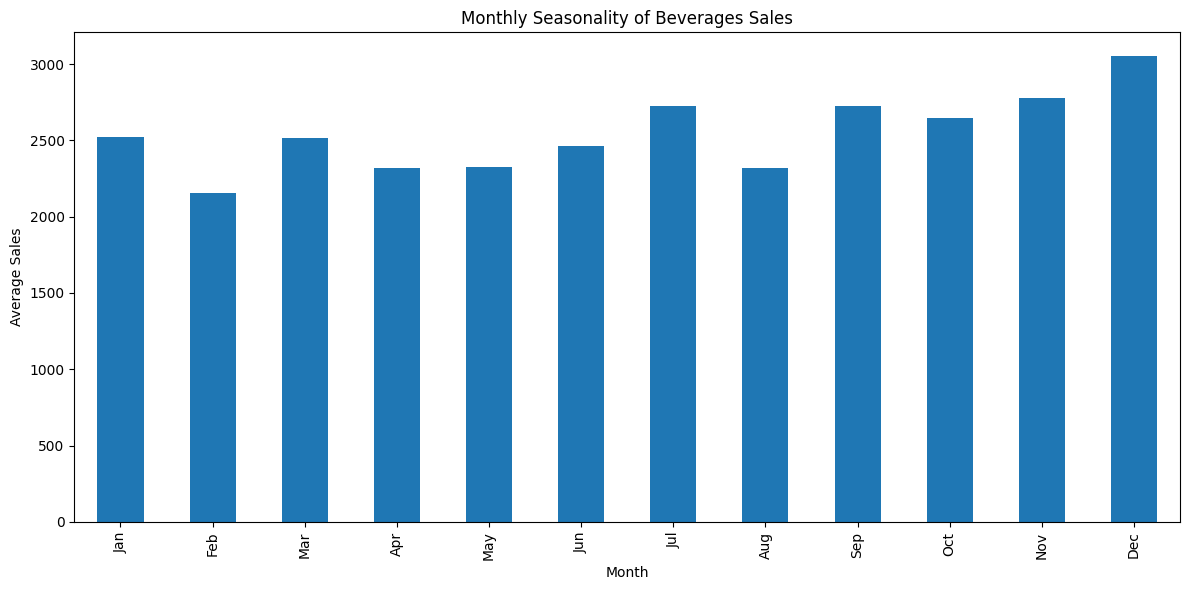

Monthly Seasonal Patterns:
date
1     2520.343727
2     2152.506228
3     2518.200441
4     2317.078283
5     2323.318668
6     2464.286525
7     2725.897977
8     2319.338957
9     2725.644580
10    2650.016889
11    2778.797219
12    3055.753864
Name: (sales, BEVERAGES), dtype: float64


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

# Convert index to timestamp if it's not already
sales = beverages_sales[('sales', 'BEVERAGES')].copy()
# sales.index = pd.to_datetime(sales.index)

# Ensure the series is in a regular time series format
sales = sales.to_timestamp()

# Perform seasonal decomposition
# Use a period that makes sense for your data
decomposition = seasonal_decompose(sales, period=30)  # Using 30 days as a monthly period

# Create a figure with multiple subplots
plt.figure(figsize=(20, 12))

# Plot original data
plt.subplot(411)
plt.plot(sales)
plt.title('Original Time Series')

# Plot trend
plt.subplot(412)
plt.plot(decomposition.trend)
plt.title('Trend')

# Plot seasonal component
plt.subplot(413)
plt.plot(decomposition.seasonal)
plt.title('Seasonality')

# Plot residuals
plt.subplot(414)
plt.plot(decomposition.resid)
plt.title('Residuals')

plt.tight_layout()
plt.show()

# Monthly seasonality analysis
def analyze_monthly_seasonality(series):
    # Group by month and calculate mean to see monthly patterns
    monthly_seasonal = series.groupby(series.index.month).mean()
    
    # Plot monthly seasonality
    plt.figure(figsize=(12, 6))
    monthly_seasonal.plot(kind='bar')
    plt.title('Monthly Seasonality of Beverages Sales')
    plt.xlabel('Month')
    plt.ylabel('Average Sales')
    plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
    plt.tight_layout()
    plt.show()
    
    return monthly_seasonal

# Perform monthly seasonality analysis
monthly_pattern = analyze_monthly_seasonality(sales)
print("Monthly Seasonal Patterns:")
print(monthly_pattern)

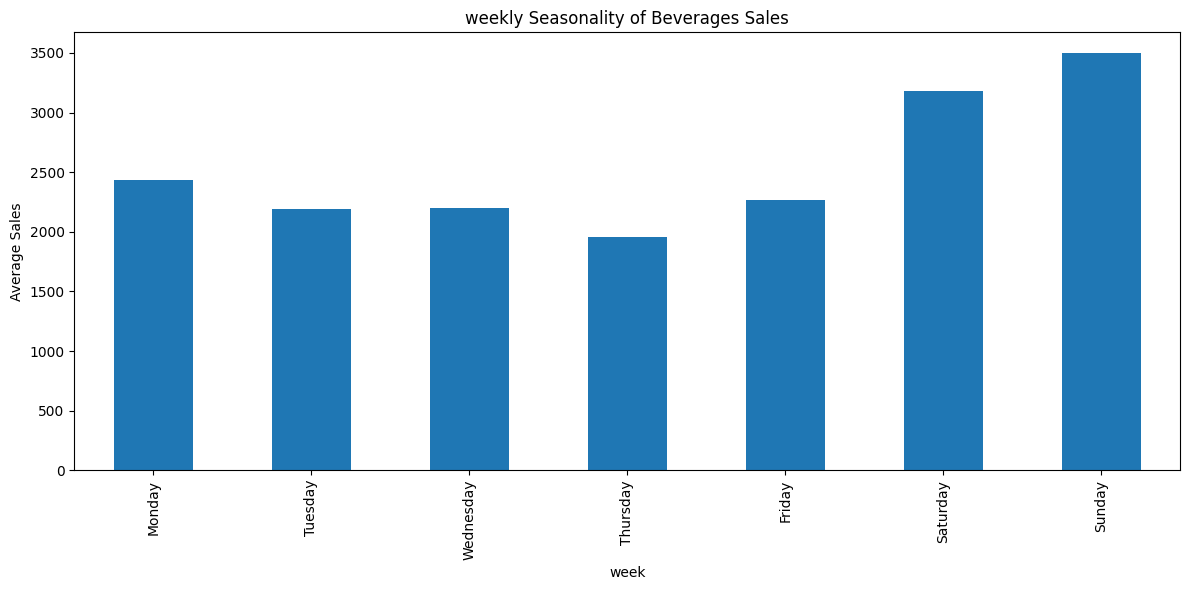

Weekly Seasonal Patterns:
date
0    2432.116959
1    2188.721989
2    2197.566867
3    1954.741085
4    2266.102866
5    3181.634219
6    3498.005678
Name: (sales, BEVERAGES), dtype: float64


In [30]:
def analyze_weekly_seasonality(series):
    # Group by month and calculate mean to see monthly patterns
    weekly_seasonal = series.groupby(series.index.weekday).mean()
    
    # Plot monthly seasonality
    plt.figure(figsize=(12, 6))
    weekly_seasonal.plot(kind='bar')
    plt.title('weekly Seasonality of Beverages Sales')
    plt.xlabel('week')
    plt.ylabel('Average Sales')
    plt.xticks(range(7), ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
    plt.tight_layout()
    plt.show()
    
    return weekly_seasonal

# Perform monthly seasonality analysis
weekly_pattern = analyze_weekly_seasonality(sales)
print("Weekly Seasonal Patterns:")
print(weekly_pattern)

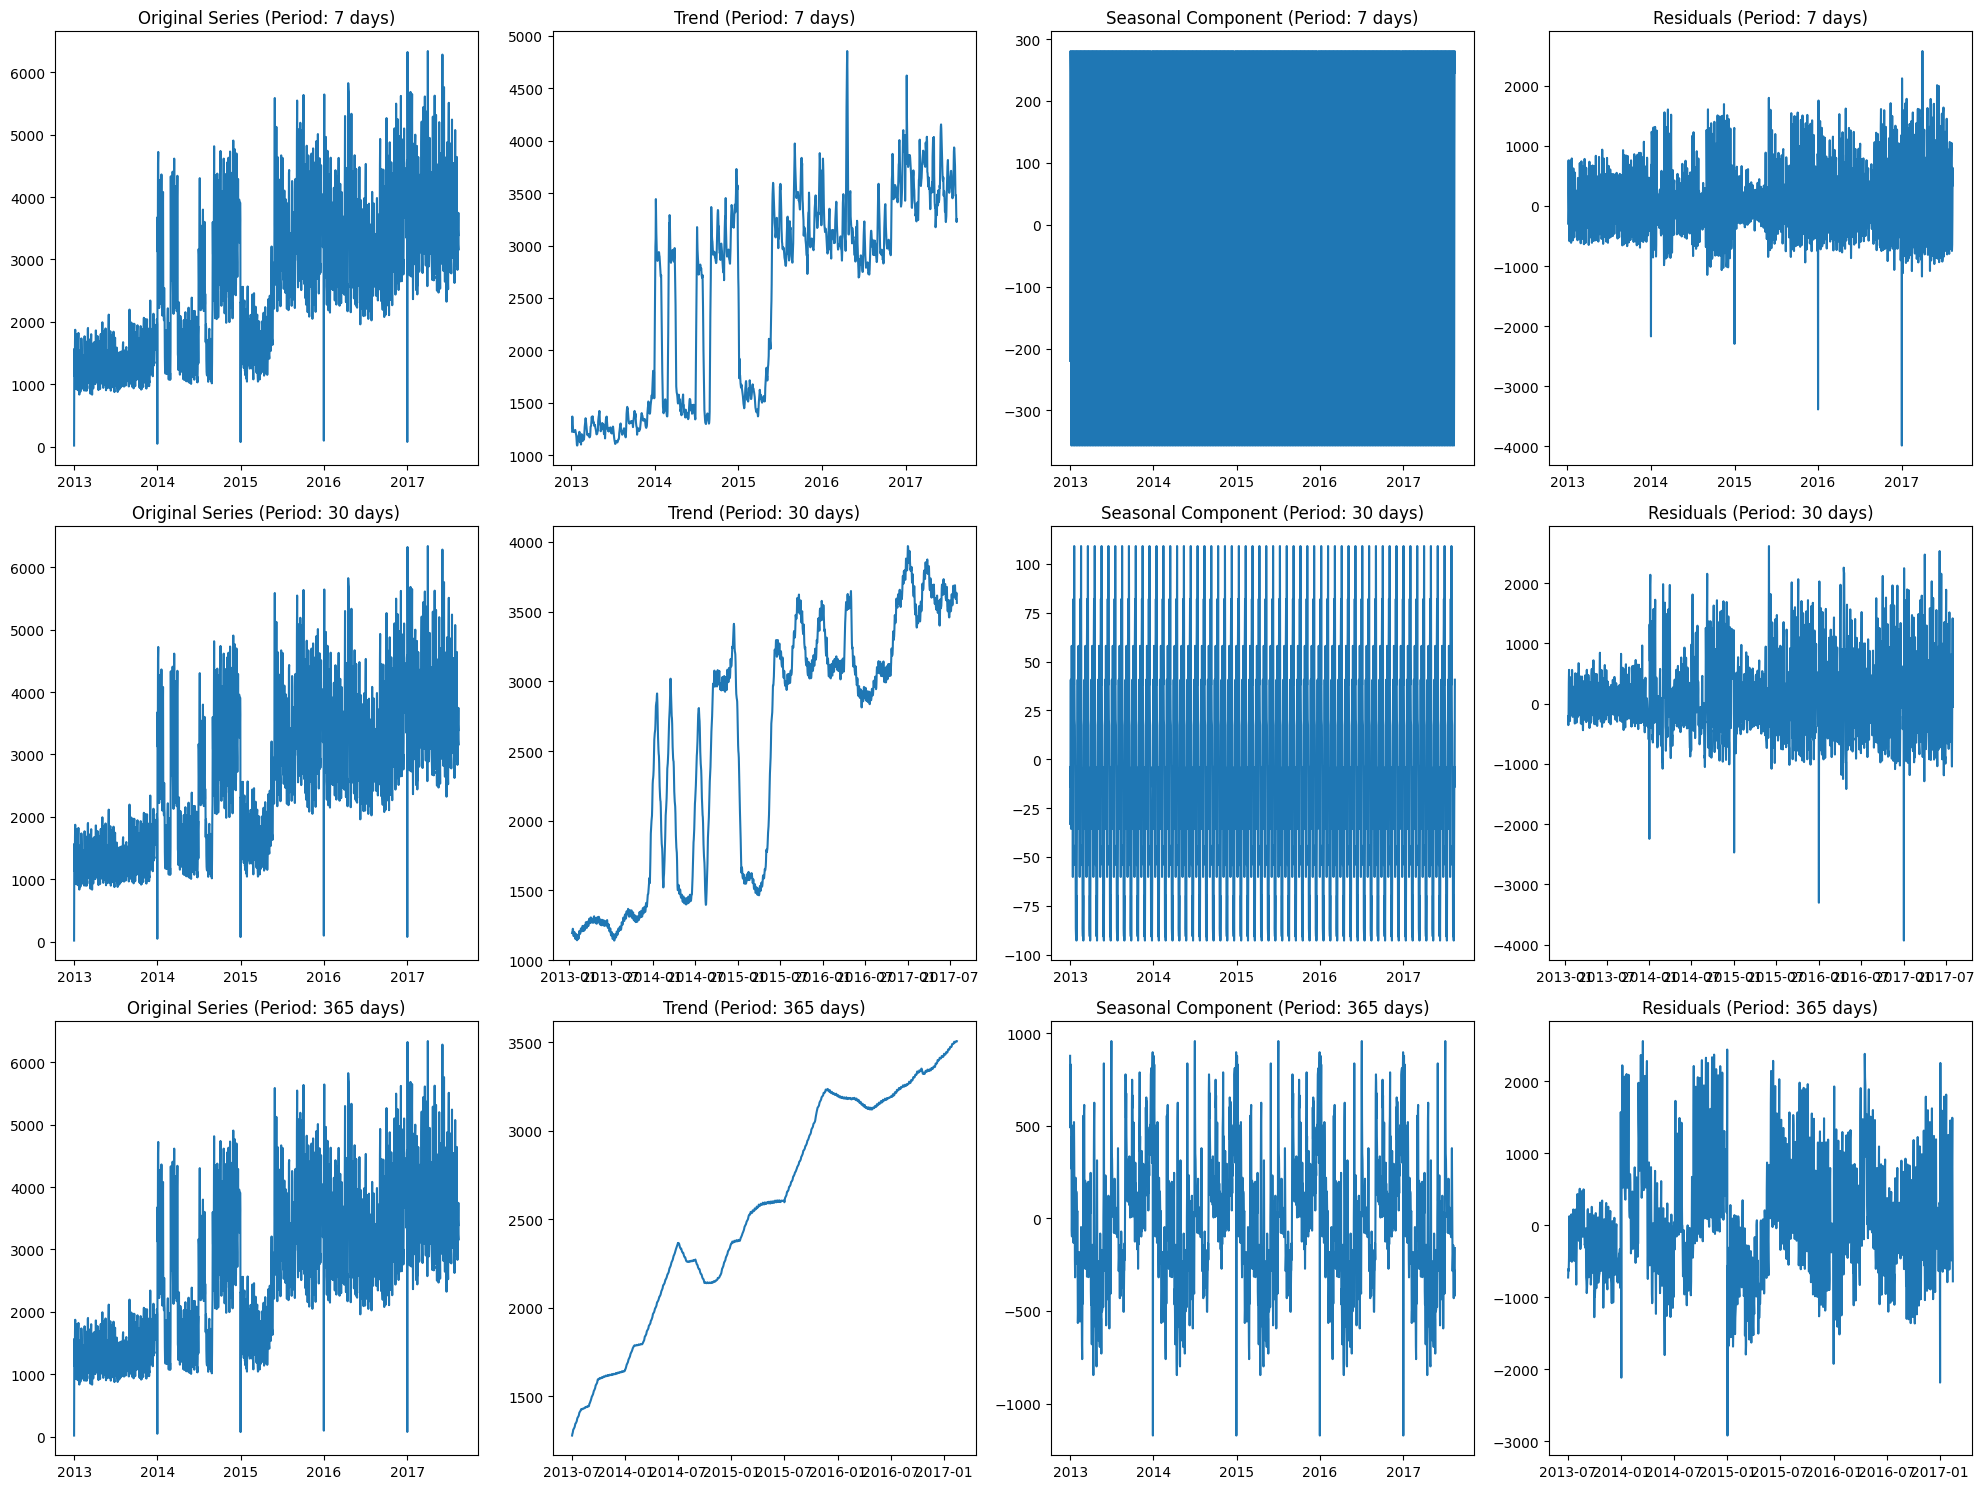

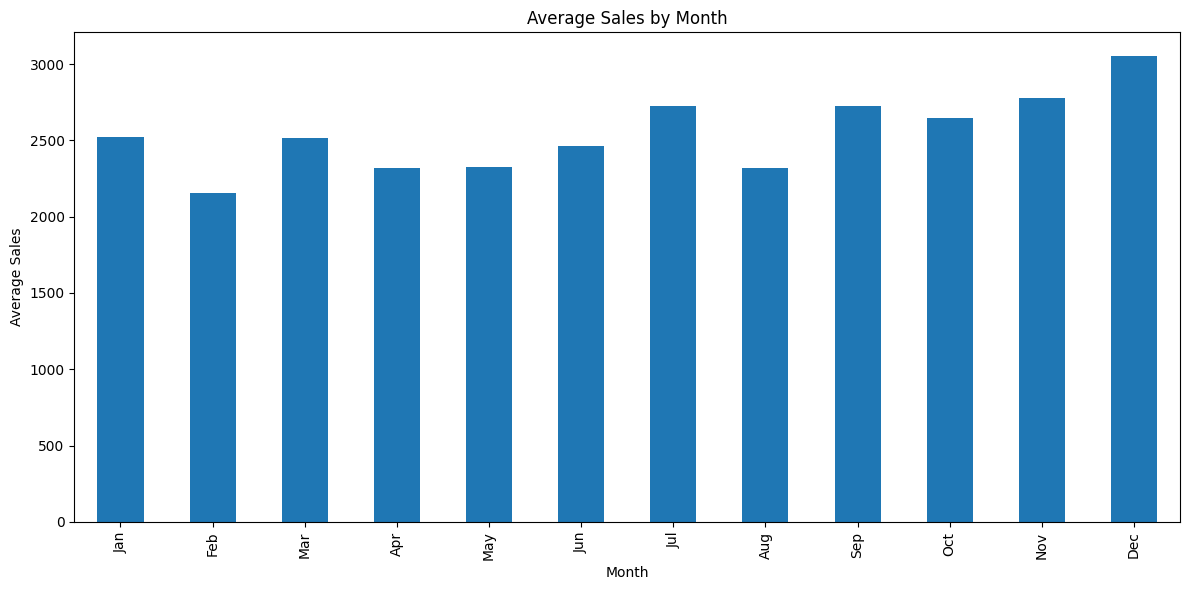

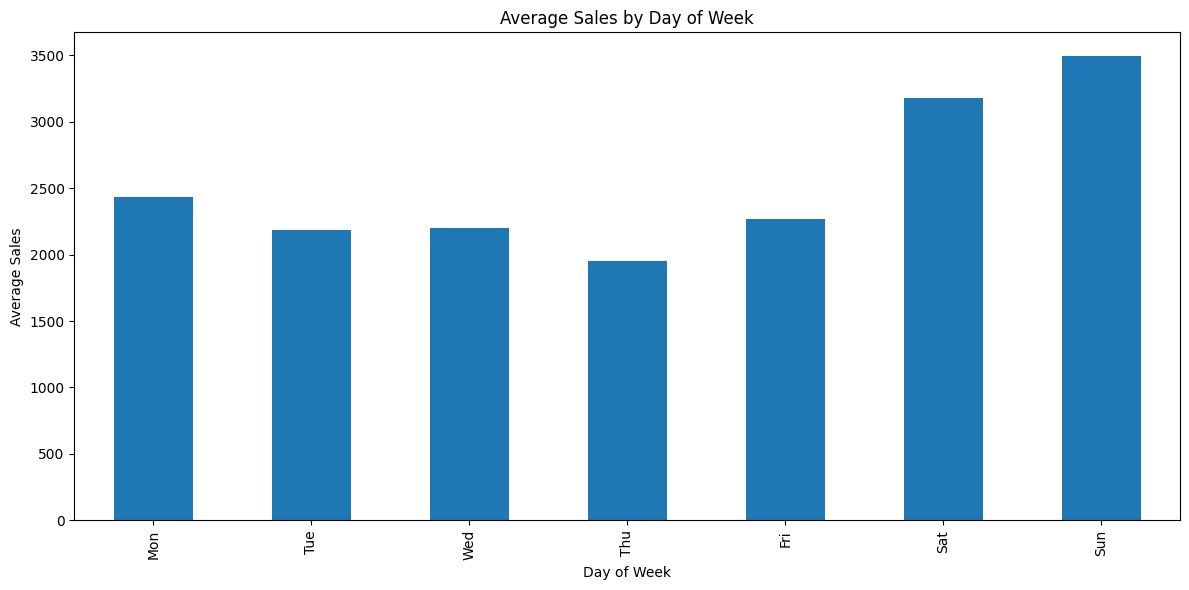

Seasonality Test Results:

Period: 7 days
ADF Statistic: -9.668034673166687
p-value: 1.2992693453833861e-16
Significant Seasonality: Yes

Period: 30 days
ADF Statistic: -9.614936716680129
p-value: 1.7707420248239094e-16
Significant Seasonality: Yes

Period: 365 days
ADF Statistic: -4.926509572452088
p-value: 3.095919747905566e-05
Significant Seasonality: Yes


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import stats

# Prepare the data
sales = beverages_sales[('sales', 'BEVERAGES')].copy()
sales = sales.to_timestamp()

# 1. Seasonal Decomposition
# Try different periods
periods = [7, 30, 365]  # weekly, monthly, yearly
plt.figure(figsize=(20, 15))

for i, period in enumerate(periods, 1):
    try:
        decomposition = seasonal_decompose(sales, period=period)
        
        plt.subplot(len(periods), 4, 4*i-3)
        plt.plot(sales)
        plt.title(f'Original Series (Period: {period} days)')
        
        plt.subplot(len(periods), 4, 4*i-2)
        plt.plot(decomposition.trend)
        plt.title(f'Trend (Period: {period} days)')
        
        plt.subplot(len(periods), 4, 4*i-1)
        plt.plot(decomposition.seasonal)
        plt.title(f'Seasonal Component (Period: {period} days)')
        
        plt.subplot(len(periods), 4, 4*i)
        plt.plot(decomposition.resid)
        plt.title(f'Residuals (Period: {period} days)')
    except Exception as e:
        print(f"Error with period {period}: {e}")

plt.tight_layout()
plt.show()

# 2. Monthly Seasonality
monthly_avg = sales.groupby(sales.index.month).mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar')
plt.title('Average Sales by Month')
plt.xlabel('Month')
plt.ylabel('Average Sales')
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.tight_layout()
plt.show()

# 3. Day of Week Seasonality
daily_avg = sales.groupby(sales.index.dayofweek).mean()
plt.figure(figsize=(12, 6))
daily_avg.plot(kind='bar')
plt.title('Average Sales by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Sales')
plt.xticks(range(7), ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])
plt.tight_layout()
plt.show()

# 4. Statistical Tests for Seasonality
from statsmodels.tsa.stattools import adfuller

def check_seasonality(data, periods):
    results = {}
    for period in periods:
        # Create seasonal difference
        seasonal_diff = data - data.shift(period)
        
        # Perform Augmented Dickey-Fuller test
        adf_result = adfuller(seasonal_diff.dropna())
        
        results[period] = {
            'ADF Statistic': adf_result[0],
            'p-value': adf_result[1]
        }
    
    return results

# Check seasonality for different periods
seasonality_test = check_seasonality(sales, [7, 30, 365])
print("Seasonality Test Results:")
for period, result in seasonality_test.items():
    print(f"\nPeriod: {period} days")
    print(f"ADF Statistic: {result['ADF Statistic']}")
    print(f"p-value: {result['p-value']}")
    print("Significant Seasonality:" + (" Yes" if result['p-value'] < 0.05 else " No"))

In [32]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# # Prepare the sales data
# sales = beverages_sales[('sales', 'BEVERAGES')].copy()
# # sales.index = pd.to_datetime(sales.index)
# sales = sales.to_timestamp()
# # Create periodogram
# plt.figure(figsize=(20, 6))

# # Scipy Periodogram
# f, Pxx_spec = signal.periodogram(sales, scaling='spectrum')

# # Plot the periodogram
# plt.semilogy(f, Pxx_spec)
# plt.title('Periodogram of Beverages Sales')
# plt.xlabel('Frequency')
# plt.ylabel('Power Spectral Density')
# plt.tight_layout()
# plt.show()

In [33]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from scipy import signal

# # Prepare the sales data
# sales = beverages_sales[('sales', 'BEVERAGES')].copy()
# # sales.index = pd.to_datetime(sales.index)
# sales = sales.to_timestamp()
# # Create the periodogram with clearer frequency interpretation
# plt.figure(figsize=(20, 6))

# # Calculate periodogram
# f, Pxx_spec = signal.periodogram(sales, detrend='linear')

# # Convert frequency to period (in days)
# periods = 1 / f

# # Filter out very long and very short periods
# mask = (periods > 2) & (periods < len(sales) / 2)
# filtered_periods = periods[mask]
# filtered_pxx = Pxx_spec[mask]

# # Plot
# plt.plot(filtered_periods, filtered_pxx)
# plt.title('Periodogram of Beverages Sales')
# plt.xlabel('Period (days)')
# plt.ylabel('Power')
# plt.xscale('log')
# plt.yscale('log')
# plt.grid(True)

# # Annotate top peaks
# top_indices = np.argsort(filtered_pxx)[-5:][::-1]
# for idx in top_indices:
#     period = filtered_periods[idx]
#     power = filtered_pxx[idx]
#     plt.annotate(f'{period:.1f} days', 
#                  xy=(period, power), 
#                  xytext=(10, 10),
#                  textcoords='offset points',
#                  ha='left',
#                  va='bottom',
#                  bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#                  arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# plt.tight_layout()
# plt.show()

# # Print out the top periods
# print("Top Periods:")
# for idx in top_indices:
#     print(f"Period: {filtered_periods[idx]:.1f} days, Power: {filtered_pxx[idx]:.2f}")